## 데이터 준비

In [42]:
import pandas
import konlpy
import gensim

In [40]:
# 데이터를 읽어봅시다. 
import pandas as pd
train_data = pd.read_table('~/data/ratings_train.txt')
test_data = pd.read_table('~/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [41]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace = True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word : index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [43]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [44]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포

In [45]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 적절한 최대 문장 길이 지정

### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [46]:
import tensorflow as tf
import os

x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## 모델 구성 및 validation set 구성

In [47]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [48]:
### 훈련용 데이터셋 몇건?
# validation set 
x_val = x_train[:48727]   
y_val = y_train[:48727]

# validation set을 제외한 나머지 
partial_x_train = x_train[48727:]  
partial_y_train = y_train[48727:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(97455, 41)
(97455,)


## 모델 훈련 개시

In [49]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
191/191 [==============================] - 2s 6ms/step - loss: 0.5166 - accuracy: 0.7296 - val_loss: 0.3609 - val_accuracy: 0.8423
Epoch 2/20
191/191 [==============================] - 1s 5ms/step - loss: 0.3339 - accuracy: 0.8586 - val_loss: 0.3433 - val_accuracy: 0.8507
Epoch 3/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2963 - accuracy: 0.8769 - val_loss: 0.3409 - val_accuracy: 0.8518
Epoch 4/20
191/191 [==============================] - 1s 6ms/step - loss: 0.2672 - accuracy: 0.8903 - val_loss: 0.3544 - val_accuracy: 0.8491
Epoch 5/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2391 - accuracy: 0.9046 - val_loss: 0.3631 - val_accuracy: 0.8479
Epoch 6/20
191/191 [==============================] - 1s 5ms/step - loss: 0.2095 - accuracy: 0.9194 - val_loss: 0.3800 - val_accuracy: 0.8461
Epoch 7/20
191/191 [==============================] - 1s 5ms/step - loss: 0.1780 - accuracy: 0.9343 - val_loss: 0.4122 - val_accuracy: 0.8418
Epoch 

In [50]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.0309 - accuracy: 0.8138
[1.0308934450149536, 0.813759982585907]


## Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


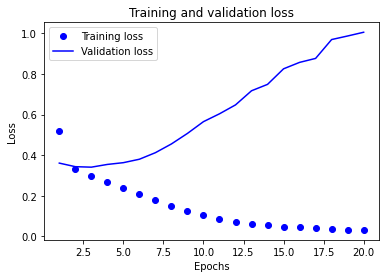

In [51]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

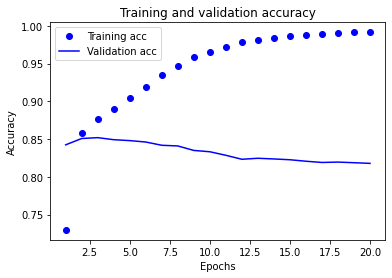

In [52]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

 ## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [53]:
import gensim

In [56]:
from gensim.models import Word2Vec

In [63]:
model_path = '/aiffel/data/word2vec_ko.model'

In [72]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(model_path)
vector = word_vectors.wv['끝']
vector.shape

(100,)

In [74]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding matrix에 word2vec 워드를 단어 하나식마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

/tmp/ipykernel_260/2168914698.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_to_word[i] in vector:


In [76]:
from tensorflow import keras

In [77]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                        embeddings_initializer = Constant(embedding_matrix),
                        input_length = maxlen,
                        trainable = True))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [78]:
# 학습하기
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])
epochs = 20
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = epochs,
                   batch_size = 512, validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/20
191/191 [==============================] - 3s 9ms/step - loss: 0.6194 - accuracy: 0.6462 - val_loss: 0.4587 - val_accuracy: 0.7923
Epoch 2/20
191/191 [==============================] - 1s 7ms/step - loss: 0.3995 - accuracy: 0.8223 - val_loss: 0.3757 - val_accuracy: 0.8332
Epoch 3/20
191/191 [==============================] - 1s 8ms/step - loss: 0.3372 - accuracy: 0.8556 - val_loss: 0.3558 - val_accuracy: 0.8461
Epoch 4/20
191/191 [==============================] - 1s 7ms/step - loss: 0.3024 - accuracy: 0.8732 - val_loss: 0.3556 - val_accuracy: 0.8465
Epoch 5/20
191/191 [==============================] - 1s 7ms/step - loss: 0.2762 - accuracy: 0.8877 - val_loss: 0.3541 - val_accuracy: 0.8487
Epoch 6/20
191/191 [==============================] - 1s 7ms/step - loss: 0.2534 - accuracy: 0.8981 - val_loss: 0.3644 - val_accuracy: 0.8447
Epoch 7/20
191/191 [==============================] - 1s 7ms/step - loss: 0.2256 - accuracy: 0.9111 - val_loss: 0.3713 - val_accuracy: 0.8463
Epoch 

In [79]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.7101 - accuracy: 0.8176
[0.7100896239280701, 0.8176251649856567]


# 회고
### 프로그램 작성에 집중하느라, 전체적인 흐름에 대한 이해가 아직 부족하다.   
### 처음부터 꼭 다시 한 번 리뷰하는 시간을 가질 예정이다.
### 'Unpickling error'를 해결하는 데에 시간이 많이 소요되었다. 결국은 경로 문제였음...잘 확인하기!!